In [222]:
import pypots
import numpy as np
import matplotlib.pyplot as plt
import tsdb
import benchpots
from pypots.optim import Adam
from pypots.imputation import CSDI, MRNN, BRITS

from pypots.utils.random import set_random_seed
from pypots.utils.metrics import calc_mae

from cdrec.python.recovery import centroid_recovery as CDrec

set_random_seed(1234)



2024-10-02 19:26:12 [INFO]: Have set the random seed as 1234 for numpy and pytorch.


In [43]:
ecg200_2 = benchpots.datasets.preprocess_ucr_uea_datasets('ucr_uea_ECG200', 0)
ecg200_2.keys()

2024-10-02 18:23:26 [INFO]: You're using dataset ucr_uea_ECG200, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/ucr_uea_datasets
2024-10-02 18:23:26 [INFO]: Dataset ucr_uea_ECG200 has already been downloaded. Processing directly...
2024-10-02 18:23:26 [INFO]: Dataset ucr_uea_ECG200 has already been cached. Loading from cache directly...
2024-10-02 18:23:26 [INFO]: Loaded successfully!
2024-10-02 18:23:26 [WARNING]: rate is 0, no missing values are artificially added.
2024-10-02 18:23:26 [INFO]: Total sample number: 200
2024-10-02 18:23:26 [INFO]: Training set size: 80 (40.00%)
2024-10-02 18:23:26 [INFO]: Validation set size: 20 (10.00%)
2024-10-02 18:23:26 [INFO]: Test set size: 100 (50.00%)
2024-10-02 18:23:26 [INFO]: Number of steps: 1
2024-10-02 18:23:26 [INFO]: Number of features: 96
2024-10-02 18:23:26 [INFO]: Train set missing rate: 0.00%
2024-10-02 18:23:26 [INFO]: Valid

dict_keys(['n_steps', 'n_features', 'scaler', 'train_X', 'train_y', 'val_X', 'val_y', 'test_X', 'test_y', 'label_encoder'])

In [13]:
ecg200 = tsdb.load('ucr_uea_ECG200')

2024-10-02 18:10:29 [INFO]: You're using dataset ucr_uea_ECG200, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/ucr_uea_datasets
2024-10-02 18:10:29 [INFO]: Dataset ucr_uea_ECG200 has already been downloaded. Processing directly...
2024-10-02 18:10:29 [INFO]: Dataset ucr_uea_ECG200 has already been cached. Loading from cache directly...
2024-10-02 18:10:29 [INFO]: Loaded successfully!


In [66]:
X_train = ecg200['X_train'].transpose([0,2,1])
y_train = ecg200['y_train']

X_test = ecg200['X_test'].transpose([0,2,1])
y_test = ecg200['y_test']
n_steps = len(X_test[0])

array([nan])

In [194]:
# initialize the model
csdi = CSDI(
    n_steps=n_steps,
    n_features=1,
    n_layers=6,
    n_heads=2,
    n_channels=128,
    d_time_embedding=64,
    d_feature_embedding=32,
    d_diffusion_embedding=128,
    target_strategy="random",
    n_diffusion_steps=50,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=100,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    #patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files 
    saving_path="results/csdi",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)


2024-10-02 19:05:32 [INFO]: No given device, using default device: cpu
2024-10-02 19:05:32 [INFO]: Model files will be saved to results/csdi/20241002_T190532
2024-10-02 19:05:32 [INFO]: Tensorboard file will be saved to results/csdi/20241002_T190532/tensorboard
2024-10-02 19:05:32 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 1,693,601


In [195]:
csdi.fit(train_set={'X':X_train})

2024-10-02 19:05:33 [INFO]: Epoch 001 - training loss: 0.8987
2024-10-02 19:05:33 [INFO]: Epoch 002 - training loss: 0.7482
2024-10-02 19:05:34 [INFO]: Epoch 003 - training loss: 0.6030
2024-10-02 19:05:34 [INFO]: Epoch 004 - training loss: 0.7119
2024-10-02 19:05:34 [INFO]: Epoch 005 - training loss: 0.4634
2024-10-02 19:05:35 [INFO]: Epoch 006 - training loss: 0.5131
2024-10-02 19:05:35 [INFO]: Epoch 007 - training loss: 0.4459
2024-10-02 19:05:35 [INFO]: Epoch 008 - training loss: 0.4373
2024-10-02 19:05:36 [INFO]: Epoch 009 - training loss: 0.4527
2024-10-02 19:05:36 [INFO]: Epoch 010 - training loss: 0.3740
2024-10-02 19:05:36 [INFO]: Epoch 011 - training loss: 0.3739
2024-10-02 19:05:37 [INFO]: Epoch 012 - training loss: 0.4459
2024-10-02 19:05:37 [INFO]: Epoch 013 - training loss: 0.3890
2024-10-02 19:05:37 [INFO]: Epoch 014 - training loss: 0.3384
2024-10-02 19:05:38 [INFO]: Epoch 015 - training loss: 0.4698
2024-10-02 19:05:38 [INFO]: Epoch 016 - training loss: 0.3124
2024-10-

In [196]:
X_test_corr = X_test.copy()
inds = range(5,21)

for samp in X_test_corr:
    samp[inds] = np.nan
    
mask = np.isnan(X_test_corr)


In [198]:
csdi_imputed = csdi.impute(test_set={'X': X_test_corr}).squeeze(axis=1)


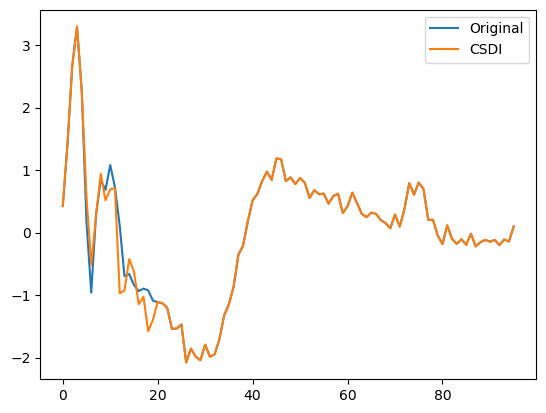

In [202]:
plt.plot(X_test[0][:])
plt.plot(csdi_imputed[0][:])
plt.legend(["Original", "CSDI"])
plt.show()

In [200]:
testing_mae = calc_mae(
    csdi_imputed,
    X_test,
    mask
)
print(f"Testing mean absolute error: {testing_mae:.4f}")

Testing mean absolute error: 0.5924


In [208]:
mrnn = MRNN(
    n_steps=n_steps,
    n_features=1,
    rnn_hidden_size=128,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=100,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    # patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="results/imputation/mrnn",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

2024-10-02 19:08:19 [INFO]: No given device, using default device: cpu
2024-10-02 19:08:19 [INFO]: Model files will be saved to results/imputation/mrnn/20241002_T190819
2024-10-02 19:08:19 [INFO]: Tensorboard file will be saved to results/imputation/mrnn/20241002_T190819/tensorboard
2024-10-02 19:08:19 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 102,407


In [210]:
mrnn.fit(train_set={'X':X_train})

2024-10-02 19:08:35 [INFO]: Epoch 001 - training loss: 2.0393
2024-10-02 19:08:35 [INFO]: Epoch 002 - training loss: 1.8863
2024-10-02 19:08:35 [INFO]: Epoch 003 - training loss: 1.7042
2024-10-02 19:08:35 [INFO]: Epoch 004 - training loss: 1.4802
2024-10-02 19:08:35 [INFO]: Epoch 005 - training loss: 1.4476
2024-10-02 19:08:35 [INFO]: Epoch 006 - training loss: 1.3876
2024-10-02 19:08:36 [INFO]: Epoch 007 - training loss: 1.3698
2024-10-02 19:08:36 [INFO]: Epoch 008 - training loss: 1.3199
2024-10-02 19:08:36 [INFO]: Epoch 009 - training loss: 1.3075
2024-10-02 19:08:36 [INFO]: Epoch 010 - training loss: 1.2729
2024-10-02 19:08:36 [INFO]: Epoch 011 - training loss: 1.2514
2024-10-02 19:08:36 [INFO]: Epoch 012 - training loss: 1.2325
2024-10-02 19:08:36 [INFO]: Epoch 013 - training loss: 1.2118
2024-10-02 19:08:37 [INFO]: Epoch 014 - training loss: 1.2011
2024-10-02 19:08:37 [INFO]: Epoch 015 - training loss: 1.1964
2024-10-02 19:08:37 [INFO]: Epoch 016 - training loss: 1.1951
2024-10-

In [212]:
mrnn_imputed = mrnn.impute(test_set={'X': X_test_corr})

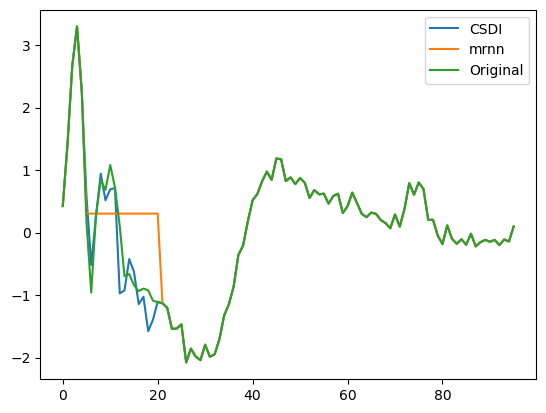

In [216]:
plt.plot(csdi_imputed[0][:])
plt.plot(mrnn_imputed[0][:])
plt.plot(X_test[0][:])
plt.legend([ "CSDI", "mrnn","Original"])
plt.show()

In [218]:
brits = BRITS(
    n_steps=n_steps,
    n_features=1,
    rnn_hidden_size=128,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=100,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    # patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files 
    saving_path="results/imputation/brits", 
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

2024-10-02 19:11:14 [INFO]: No given device, using default device: cpu
2024-10-02 19:11:14 [INFO]: Model files will be saved to results/imputation/brits/20241002_T191114
2024-10-02 19:11:14 [INFO]: Tensorboard file will be saved to results/imputation/brits/20241002_T191114/tensorboard
2024-10-02 19:11:14 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 135,952


In [219]:
brits.fit(train_set={'X':X_train})

2024-10-02 19:12:09 [INFO]: Epoch 001 - training loss: 1.6136
2024-10-02 19:12:09 [INFO]: Epoch 002 - training loss: 1.5860
2024-10-02 19:12:10 [INFO]: Epoch 003 - training loss: 1.5215
2024-10-02 19:12:11 [INFO]: Epoch 004 - training loss: 1.4479
2024-10-02 19:12:11 [INFO]: Epoch 005 - training loss: 1.3563
2024-10-02 19:12:12 [INFO]: Epoch 006 - training loss: 1.2742
2024-10-02 19:12:12 [INFO]: Epoch 007 - training loss: 1.2083
2024-10-02 19:12:13 [INFO]: Epoch 008 - training loss: 1.1512
2024-10-02 19:12:13 [INFO]: Epoch 009 - training loss: 1.1124
2024-10-02 19:12:14 [INFO]: Epoch 010 - training loss: 1.0839
2024-10-02 19:12:15 [INFO]: Epoch 011 - training loss: 1.0703
2024-10-02 19:12:15 [INFO]: Epoch 012 - training loss: 1.0457
2024-10-02 19:12:16 [INFO]: Epoch 013 - training loss: 1.0401
2024-10-02 19:12:16 [INFO]: Epoch 014 - training loss: 1.0327
2024-10-02 19:12:17 [INFO]: Epoch 015 - training loss: 1.0134
2024-10-02 19:12:17 [INFO]: Epoch 016 - training loss: 1.0000
2024-10-

In [220]:
brits_imputed = brits.impute(test_set={'X': X_test_corr})

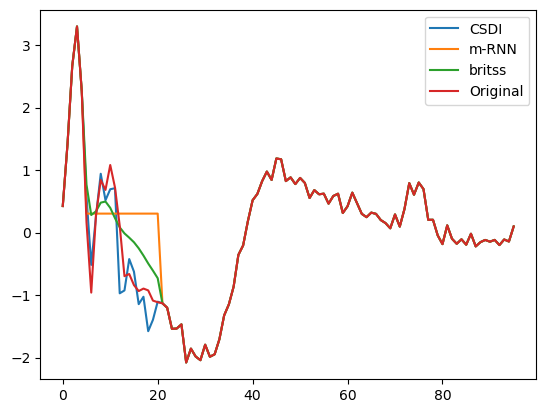

In [221]:
plt.plot(csdi_imputed[0][:])
plt.plot(mrnn_imputed[0][:])
plt.plot(brits_imputed[0][:])
plt.plot(X_test[0][:])
plt.legend([ "CSDI", "m-RNN", "britss", "Original"])
plt.show()

In [236]:
Xdata = np.concatenate([X_train.squeeze(), X_test_corr.squeeze()])
all(Xdata[0] == X_train.squeeze()[0])

True

In [238]:
cdrec_impute_raw = CDrec(Xdata)

In [252]:
cdrec_imputed = cdrec_impute_raw[100:][:].reshape([100,96,1])

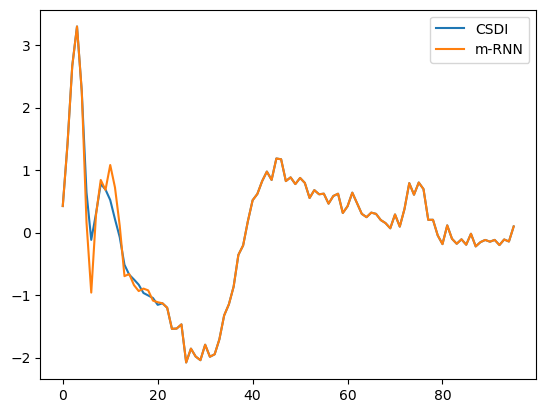

In [253]:
# plt.plot(csdi_imputed[0][:])
# plt.plot(mrnn_imputed[0][:])
# plt.plot(brits_imputed[0][:])
plt.plot(cdrec_imputed[0][:])
plt.plot(X_test[0][:])
plt.legend([ "CSDI", "m-RNN", "britss", "CDrec", "Original"])
plt.show()

In [254]:
testing_mae = calc_mae(
    csdi_imputed,
    X_test,
    mask
)
print(f"CSDI mean absolute error: {testing_mae:.4f}")

testing_mae = calc_mae(
    mrnn_imputed,
    X_test,
    mask
)
print(f"M-RNN mean absolute error: {testing_mae:.4f}")

testing_mae = calc_mae(
    brits_imputed,
    X_test,
    mask
)
print(f"BRITS mean absolute error: {testing_mae:.4f}")

testing_mae = calc_mae(
    cdrec_imputed,
    X_test,
    mask
)
print(f"CDRec mean absolute error: {testing_mae:.4f}")

CSDI mean absolute error: 0.5924
M-RNN mean absolute error: 1.0186
BRITS mean absolute error: 0.6482
CDRec mean absolute error: 0.4318


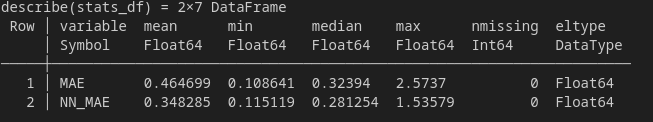

In [255]:
len(range(5,21))

16